## Import used packages

In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import spatial
from math import sin, cos, sqrt, atan2, radians
import folium
from tqdm import tqdm
import seaborn as sns

## Import data

In [2]:
bremen_trips = pd.read_csv("../data/processed/bremen.csv", index_col=0)
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])

In [3]:
bremen_trips.head(2)

,identification,start_time,end_time,weekend,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,...,humidity_2m,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min
bike,,,,,,,,,,,,,,,,,,,,,
20685,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,1,600.0,8.812554,53.076481,8.804828,53.084196,0.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0
20626,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,1,16260.0,8.884911,53.078923,8.884911,53.078923,2985.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0


In [4]:
bremen_trips.keys()

Index(['identification', 'start_time', 'end_time', 'weekend', 'duration_sec',
       'start_lng', 'start_lat', 'end_lng', 'end_lat', 'start_place',
       'end_place', 'start_plz', 'end_plz', 'temp_2m', 'humidity_2m',
       'dew_point_2m', 'max_at_2m', 'mean_speed_h/s', 'direction_degree_x',
       'max_m/s', 'min_mean_m/s', 'max_mean_m/s', 'direction_degree_y', 'min'],
      dtype='object')

## Functions that calculates distance moved towards the university of Bremen and main station

In [5]:
# Function that calculates if start or end location is closer to University of Bremen. 
# Returns the difference of the distances of the start and end location in kilometers.
# If value positive, end locations is closer to university. That means moved towards university.
def distanceToUni(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    uLat = radians(53.1069302) # University of Bremen Latitude
    uLng = radians(8.8499603)  # University of Bremen Longitude

    sdlon = uLng - sLng
    sdlat = uLat - sLat

    edlon = uLng - eLng
    edlat = uLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(uLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(uLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

def distanceToMainStation(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    msLat = radians(53.083122) # # Main station Latitude
    msLng = radians(8.813717) # # Main station Latitude

    sdlon = msLng - sLng
    sdlat = msLat - sLat

    edlon = msLng - eLng
    edlat = msLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(msLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(msLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

## Example of trip moving away from the university

- Red marker = University of Bremen
- Blue marker = Start location
- Green marker = End location

In [6]:
bremen_trips.head(2)

,identification,start_time,end_time,weekend,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,...,humidity_2m,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min
bike,,,,,,,,,,,,,,,,,,,,,
20685,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,1,600.0,8.812554,53.076481,8.804828,53.084196,0.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0
20626,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,1,16260.0,8.884911,53.078923,8.884911,53.078923,2985.0,...,92.6,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0


In [7]:
m = folium.Map(location=[53.1069302,8.8499603], zoom_start=13)

folium.Marker([53.1069302,8.8499603], popup='<i>Uni</i>',icon=folium.Icon(color='red')).add_to(m)
folium.Marker([53.083122,8.813717], popup='<i>Main Station</i>',icon=folium.Icon(color='red')).add_to(m)

row = 32
folium.Marker([bremen_trips.iloc[row,6],bremen_trips.iloc[row,5]], popup='<i>Start</i>').add_to(m)
folium.Marker([bremen_trips.iloc[row,8],bremen_trips.iloc[row,7]], popup='<i>End</i>',icon=folium.Icon(color='green')).add_to(m)

print('Moved km in direction to uni: ', distanceToUni(bremen_trips.iloc[row,5],bremen_trips.iloc[row,6],bremen_trips.iloc[row,7],bremen_trips.iloc[row,8]))
print('Moved km in direction to main station: ', distanceToMainStation(bremen_trips.iloc[row,5],bremen_trips.iloc[row,6],bremen_trips.iloc[row,7],bremen_trips.iloc[row,8]))

m

Moved km in direction to uni:  1.2799729582841826
Moved km in direction to main station:  -1.7491537704235693


## Add target variables and features to trips data

In [8]:
# Target variables lists
to_uni = []
to_main_station = []
to_uni_bool = []
to_main_station_bool = []

# Features lists
month = []
week_day = []
is_weekend = []
hour = []

for index, row in tqdm(bremen_trips.iterrows()):
    
    dist_to_uni = distanceToUni(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    dist_to_main_station = distanceToMainStation(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    
    day = row['start_time'].weekday()
    
    # Save datetime information
    month.append(row['start_time'].month)
    week_day.append(day)
    hour.append(row['start_time'].hour)
    
    if (day == 5) | (day == 6):
        is_weekend.append(1)
    else:
        is_weekend.append(0)
    
    # Save distances to corresponding list
    to_uni.append(dist_to_uni)
    to_main_station.append(dist_to_main_station)
    
    if dist_to_uni < 0:
        to_uni_bool.append(0)
    else:
        to_uni_bool.append(1)
        
    if dist_to_main_station < 0:
        to_main_station_bool.append(0)
    else:
        to_main_station_bool.append(1)
        
# Add columns to df
bremen_trips['to_uni'] = to_uni
bremen_trips['to_main_station'] = to_main_station
bremen_trips['to_uni_bool'] = to_uni_bool
bremen_trips['to_main_station_bool'] = to_main_station_bool
bremen_trips['month'] = month
bremen_trips['week_day'] = week_day
bremen_trips['is_weekend'] = is_weekend
bremen_trips['hour'] = hour

132982it [00:27, 4792.01it/s]


In [9]:
bremen_trips.sample(3)

,identification,start_time,end_time,weekend,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,...,direction_degree_y,min,to_uni,to_main_station,to_uni_bool,to_main_station_bool,month,week_day,is_weekend,hour
bike,,,,,,,,,,,,,,,,,,,,,
20833,25082955,2019-11-20 18:41:00,2019-11-20 18:52:00,0,660.0,8.787012,53.074560,8.794546,53.063867,0.0,...,160.0,0.0,-0.518068,-0.473091,0,0,11,2,0,18
20523,24180991,2019-10-29 07:21:00,2019-10-29 07:49:00,0,1680.0,8.820670,53.048502,8.777460,53.090978,2975.0,...,260.0,0.0,1.630408,1.303824,1,1,10,1,0,7
20696,15098720,2019-09-12 10:57:00,2019-09-12 11:03:00,0,360.0,8.826062,53.096249,8.830991,53.097828,0.0,...,250.0,0.0,0.367985,-0.324908,1,0,9,3,0,10


### Drop all information that are not available before a trips ends

In [10]:
bremen_trips.drop(columns={'identification','end_time','end_lng','end_lat','end_place','end_plz','duration_sec'}, inplace=True)

## Precheck on correlations to_uni_bool

In [11]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_uni_bool'])

weekend              -0.005010
start_lng            -0.133347
start_lat            -0.195841
start_place           0.046683
start_plz            -0.045094
temp_2m              -0.001080
humidity_2m          -0.010253
dew_point_2m         -0.009290
max_at_2m            -0.000849
mean_speed_h/s        0.008478
direction_degree_x    0.001225
max_m/s               0.008689
min_mean_m/s          0.005539
max_mean_m/s          0.008847
direction_degree_y    0.000821
min                   0.009373
month                -0.017886
week_day             -0.003856
is_weekend           -0.005010
hour                  0.007958
dtype: float64

- only start_lng and start_lat show significant correlations, anyway we check try to take more features into account

### Pearson correlation only for attributes with correlation higher than 0.005

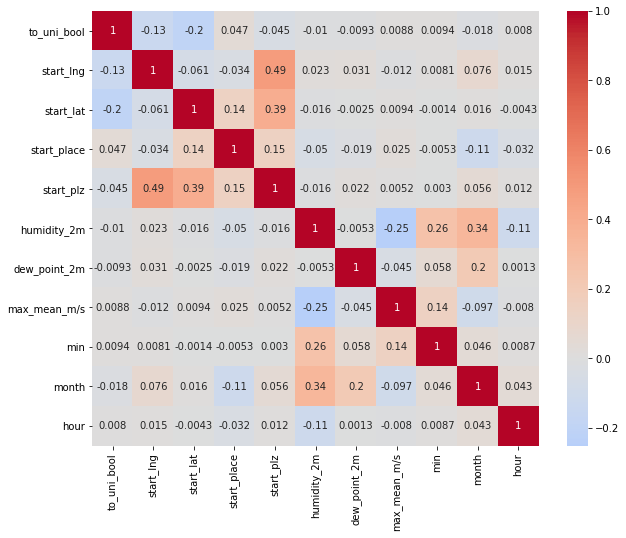

In [12]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni_bool','start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

# Predicting to_uni_bool - Classification

### Random Forest

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Feature selection
### Train on all features with correlation > 0.005

In [14]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [15]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Check on feature importance

In [16]:
names = ['start_lng','start_lat','start_place','start_plz','humidity_2m','dew_point_2m','max_mean_m/s','min','month','hour']
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

[(0.1827, 'start_lng'), (0.1708, 'start_lat'), (0.1495, 'humidity_2m'), (0.141, 'dew_point_2m'), (0.1338, 'max_mean_m/s'), (0.0959, 'hour'), (0.0625, 'month'), (0.0301, 'start_plz'), (0.017, 'start_place'), (0.0167, 'min')]


### Only train on features with importance > 0.1

In [17]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [18]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Evaluation

In [19]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))

Training accuracy: 0.998026018950218


- looks like overfitting --> perform grid search to optimize hyperparameters

### Performing grid search to optimize hyperparameters

In [20]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='accuracy', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [21]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.6355433  0.63695325 0.63967916 0.63867653 0.63877052 0.6383632
 0.63883319 0.58951623 0.64083845 0.64500564 0.64412834 0.644097
 0.64284371 0.64394034 0.63786189 0.64437899 0.64691691 0.64591427
 0.6470109  0.64738689 0.64766888 0.64647826 0.64898484 0.653716
 0.65387267 0.6547813  0.65415466 0.65424865 0.63779922 0.65161674
 0.65841584 0.65684923 0.65722522 0.65738188 0.65782053]
25 7 42


### Train model with optimized hyperparameters

In [22]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [23]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6601368626861183
Valiation accuracy: 0.6519927309186615


- looks like the model generalizes well with optimized hyperparameters

### Visualize predicted classes 0: trip not in direction to uni, 1: trip in direction to uni

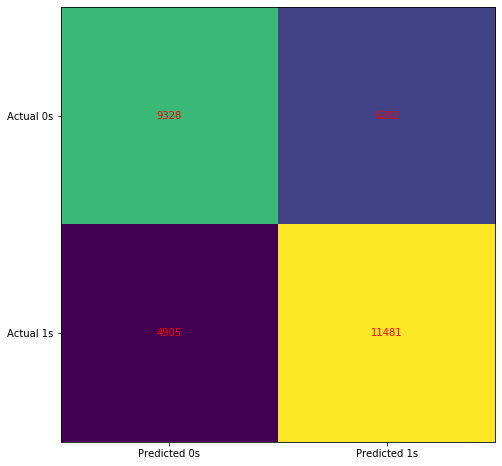

In [24]:
# Function that plots a confusion matrix given independent and target variable
def confusionMatrix(y_true, y_predicted):
    cm = confusion_matrix(y_true, y_predicted)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

confusionMatrix(y_val, rf.predict(X_val))

### Classification report

In [25]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63     15530
           1       0.65      0.70      0.67     16386

    accuracy                           0.65     31916
   macro avg       0.65      0.65      0.65     31916
weighted avg       0.65      0.65      0.65     31916



## Apply to test set

### Add validation set to train set to obtain more training data

In [26]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [27]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Training + validation set performance

In [28]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6663650890633078
Valiation accuracy: 0.665966913147011


### Test set performance

### The moment of truth

In [29]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6592931445043239


In [30]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65     23329
           1       0.67      0.66      0.67     24545

    accuracy                           0.66     47874
   macro avg       0.66      0.66      0.66     47874
weighted avg       0.66      0.66      0.66     47874



- model could perform better in terms of the accuracy score, however it seems to generalize very well (train, validation and test accuracy are almost the same)
- to improve the overall accuracy we would need more features with a significant correlation

## Evaluate performance on different subsets

### For each month available of the year 2019 check predicting performance of our model

/Users/timockenga/anaconda3/envs/PDS20/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/timockenga/anaconda3/envs/PDS20/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/timockenga/anaconda3/envs/PDS20/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/timockenga/anaconda3/envs/PDS20/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/t

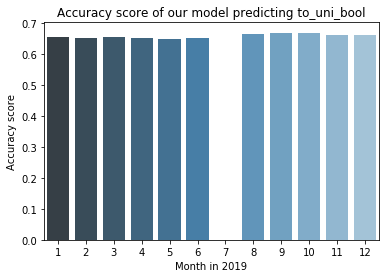

In [31]:
# Lists to save accuracy scores for all months
accuracy = []

for i in range(1,13):
    if i != 7:
        # Create subsets for evaluating on performance for the month of august
        train = bremen_trips[bremen_trips.set_index('start_time').index.month != i]
        X_train = train[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
        y_train = train[['to_uni_bool']]

        val = bremen_trips[bremen_trips.set_index('start_time').index.month == i]
        X_month = val[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
        y_month = val[['to_uni_bool']]

        # Train on all data except of august
        rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
        rf.fit(X_train, y_train)

        accuracy.append(rf.score(X_month, y_month))
    else:
        accuracy.append(0)

ax = sns.barplot(x=np.arange(1,13), y=accuracy, palette="Blues_d")
ax.set(ylabel='Accuracy score', xlabel='Month in 2019') 
ax.set_title('Accuracy score of our model predicting to_uni_bool')
plt.savefig("../reports/figures/to_uni_prediction_performance_monthly.png", dpi = 300)

- this looks great even though it would be nice if the accuracy was higher
- as predicting performance of this model is very equal for all months it seems to generalize very well

## Try Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','humidity_2m','dew_point_2m','max_mean_m/s','hour']]
y = bremen_trips['to_uni_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [34]:
model = LogisticRegression(solver='liblinear',multi_class='ovr', random_state=42, class_weight='balanced').fit(X_train, y_train)

In [35]:
print('Training accuracy: ' + str(model.score(X_train, y_train)))
print('Valiation accuracy: ' + str(model.score(X_val, y_val)))

Training accuracy: 0.5665325612874117
Valiation accuracy: 0.5604712369971174


In [36]:
model.predict_proba(X_val)

array([[0.54254207, 0.45745793],
       [0.6186332 , 0.3813668 ],
       [0.53326239, 0.46673761],
       ...,
       [0.62008444, 0.37991556],
       [0.47636136, 0.52363864],
       [0.476598  , 0.523402  ]])

In [37]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.56      0.46      0.50     15530
           1       0.56      0.66      0.61     16386

    accuracy                           0.56     31916
   macro avg       0.56      0.56      0.55     31916
weighted avg       0.56      0.56      0.56     31916



### Logistic regression performs worst than random forest. Do not use it!

# Predicting to_main_station_bool - Classification

## Precheck on correlations to_main_station_bool

In [38]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_main_station_bool'])

weekend              -0.001952
start_lng             0.064196
start_lat            -0.011609
start_place           0.084090
start_plz             0.156846
temp_2m               0.008211
humidity_2m          -0.019730
dew_point_2m         -0.004191
max_at_2m             0.008059
mean_speed_h/s        0.018921
direction_degree_x    0.001975
max_m/s               0.020770
min_mean_m/s          0.013440
max_mean_m/s          0.020182
direction_degree_y    0.002167
min                   0.003543
month                -0.018557
week_day             -0.003317
is_weekend           -0.001952
hour                 -0.035587
dtype: float64

- only start_plz shows significant correlations, anyway we check try to take more features into account

### Pearson correlation only for attributes with correlation higher than 0.005

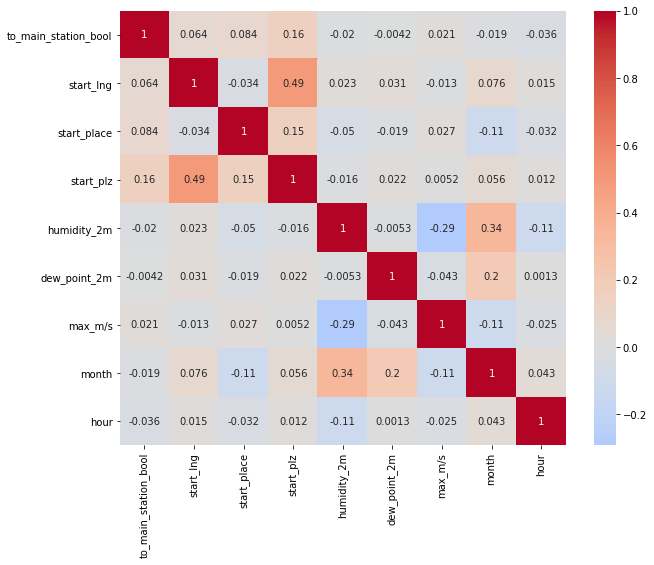

In [39]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_main_station_bool','start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

## Feature selection
### Train on all features with correlation > 0.005

In [40]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']]
y = bremen_trips['to_main_station_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [41]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Check on feature importance

In [42]:
names = ['start_lng','start_place','start_plz','humidity_2m','dew_point_2m','max_m/s','month','hour']
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

[(0.2354, 'start_lng'), (0.1715, 'humidity_2m'), (0.1628, 'dew_point_2m'), (0.1361, 'max_m/s'), (0.1071, 'hour'), (0.0916, 'start_plz'), (0.0671, 'month'), (0.0284, 'start_place')]


### Only train on features with importance > 0.1

In [43]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_plz','humidity_2m','dew_point_2m','max_m/s','hour']]
y = bremen_trips['to_main_station_bool']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

In [44]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Evaluation

In [45]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))

Training accuracy: 0.9984584147992179


- looks like overfitting --> perform grid search to optimize hyperparameters

### Performing grid search to optimize hyperparameters

In [46]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.62338639 0.64227973 0.6432197  0.63551197 0.63654593 0.63679659
 0.63689059 0.6222271  0.65067678 0.65634791 0.64441033 0.64444166
 0.64575761 0.644285   0.63403935 0.65772653 0.66380499 0.66775285
 0.65756987 0.66530894 0.66480762 0.65055145 0.66571626 0.66809751
 0.67145006 0.67123073 0.67477127 0.67452062 0.65722522 0.67614989
 0.68185236 0.68138238 0.68263567 0.68298032 0.68219702]
256 7 42


### Train model with optimized hyperparameters

In [47]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [48]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.686099413445631
Valiation accuracy: 0.6823223461586665


- looks like the model generalizes well with optimized hyperparameters

### Visualize predicted classes 0: trip not in direction to main station, 1: trip in direction to main station

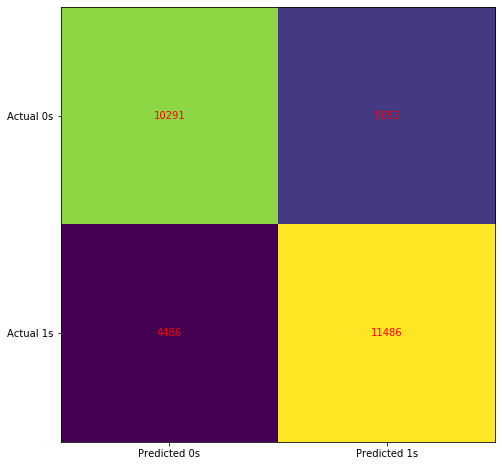

In [49]:
confusionMatrix(y_val, rf.predict(X_val))

### Classification report

In [50]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67     15944
           1       0.67      0.72      0.69     15972

    accuracy                           0.68     31916
   macro avg       0.68      0.68      0.68     31916
weighted avg       0.68      0.68      0.68     31916



## Apply to test set

### Add validation set to train set to obtain more training data

In [51]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [52]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Training + validation set performance

In [53]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6844479954880858
Valiation accuracy: 0.6844529389647825


### Test set performance

### The moment of truth

In [54]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6808915068722062


In [55]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67     23875
           1       0.67      0.71      0.69     23999

    accuracy                           0.68     47874
   macro avg       0.68      0.68      0.68     47874
weighted avg       0.68      0.68      0.68     47874



# Predicting to_uni - Regression

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Check on correlations to_uni

In [57]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_uni'])

weekend              -0.002435
start_lng            -0.181896
start_lat            -0.312919
start_place          -0.027408
start_plz            -0.112016
temp_2m              -0.001462
humidity_2m           0.001873
dew_point_2m          0.000601
max_at_2m            -0.001396
mean_speed_h/s        0.002943
direction_degree_x    0.002274
max_m/s               0.003102
min_mean_m/s          0.001066
max_mean_m/s          0.002828
direction_degree_y    0.001570
min                   0.004957
month                 0.000366
week_day             -0.002279
is_weekend           -0.002435
hour                 -0.002625
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.05

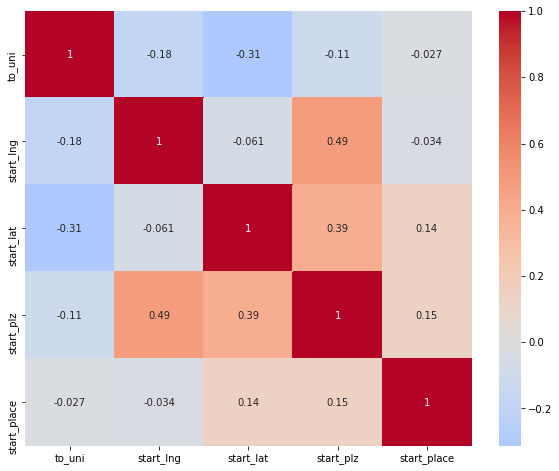

In [58]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni','start_lng','start_lat','start_plz','start_place']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

### Choose features with correlation > 0.05

In [59]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz']]
y = bremen_trips['to_uni']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

### Polynomial regression

In [60]:
def chooseDegree(X, y):
    
    # Splitting data into train and validation set
    #X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
    #X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

    r2_train = []
    r2_val = []
    rmses_val = []
    degrees = np.arange(1, 6)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)
        X_val_poly = poly_features.fit_transform(X_val)
        
        # Evaluate
        r2_train.append(poly_reg.score(X_poly_train, y_train))
        r2_val.append(poly_reg.score(X_val_poly,y_val))

        # Compare with val data
        poly_predict = poly_reg.predict(X_val_poly)
        poly_mse = mean_squared_error(y_val, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses_val.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Suggested degree {} with RMSE of validation set {}'.format(min_deg, min_rmse))
    
    # Create model with optimal degree
    poly_features = PolynomialFeatures(degree=min_deg, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    X_val_poly = poly_features.fit_transform(X_val)

    # Evaluate
    print('R2 train score with suggested degree: ', poly_reg.score(X_poly_train, y_train))
    print('R2 validation score with suggested degree: ', poly_reg.score(X_val_poly,y_val))
    
    
    # Evaluation plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    #ax_rmses_val = fig.add_subplot(111)
    axes[0].plot(degrees, rmses_val, label='rmses_val')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('RMSE')
    
    #ax_r2_train = fig.add_subplot(111)
    axes[1].plot(degrees, r2_train, label='R2_train')
    axes[1].set_yscale('linear')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_train')
    axes[1].set_label('R2_train')
    #axes[1].set_ylim(0,1)
    
    #ax_r2_val = fig.add_subplot(111)
    axes[1].plot(degrees, r2_val, label='R2_val')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_val')
    
    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()

Suggested degree 3 with RMSE of validation set 1.1948216663382907
R2 train score with suggested degree:  0.254827683865803
R2 validation score with suggested degree:  0.24271827679491464


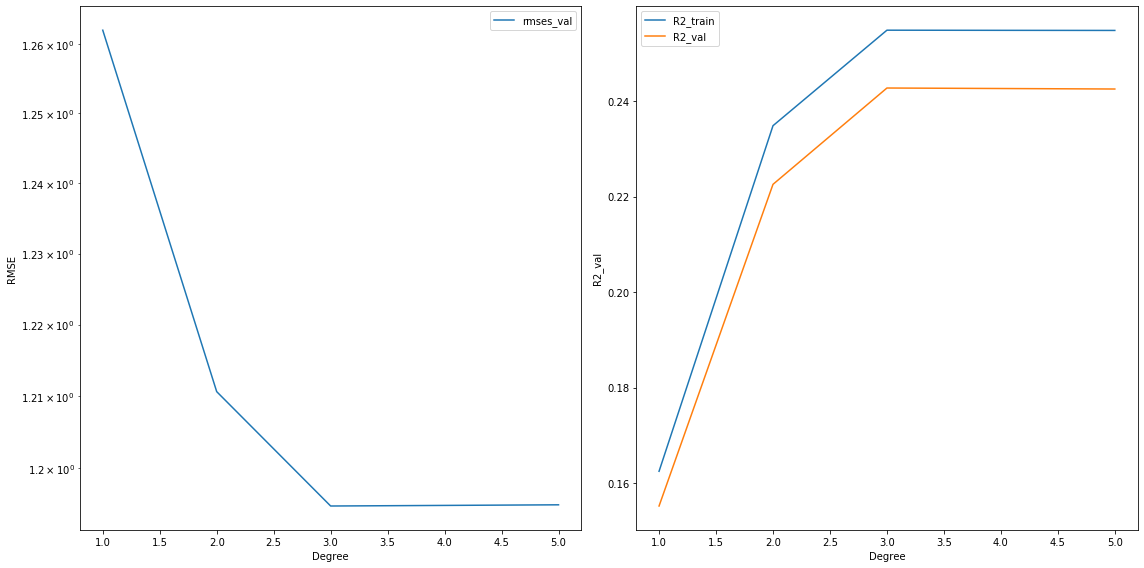

In [61]:
chooseDegree(X,y)

## Apply to test set

### Add validation set to train set to obtain more training data

In [62]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)

lin = LinearRegression()

### Training + validation set performance

In [63]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.2503648032612463

### Test set performance

In [64]:
X_test_poly = poly.fit_transform(X_test)
lin.score(X_test_poly,y_test)

0.25194418043095546

- no accurate predictions, features with higher significance required.

# Predicting to_main_station - Regression

## Check on correlations to_main_station

In [65]:
bremen_trips.drop(columns={'to_uni','to_uni_bool','to_main_station_bool','to_main_station'}).corrwith(bremen_trips['to_main_station'])

weekend              -0.005357
start_lng             0.109776
start_lat             0.005981
start_place           0.093781
start_plz             0.255585
temp_2m               0.011527
humidity_2m          -0.020052
dew_point_2m         -0.001210
max_at_2m             0.011434
mean_speed_h/s        0.013473
direction_degree_x    0.004080
max_m/s               0.015090
min_mean_m/s          0.009170
max_mean_m/s          0.014378
direction_degree_y    0.003771
min                   0.004312
month                 0.000480
week_day             -0.007564
is_weekend           -0.005357
hour                 -0.011228
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.05

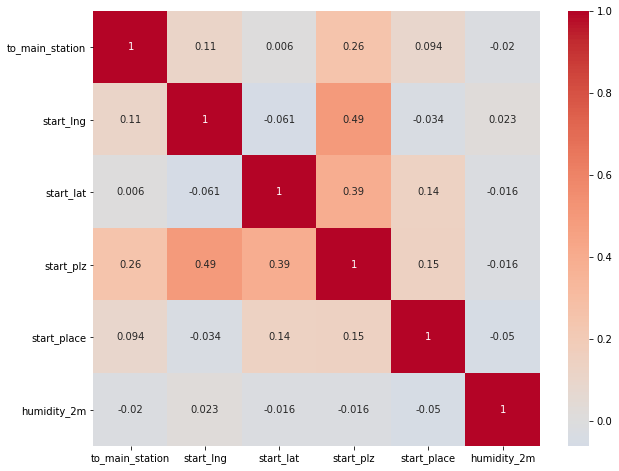

In [66]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_main_station','start_lng','start_lat','start_plz','start_place','humidity_2m']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

### Choose features with correlation > 0.05

In [67]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','start_place','humidity_2m']]
y = bremen_trips['to_main_station']

# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

### Polynomial regression

Suggested degree 4 with RMSE of validation set 1.2932983835469383
R2 train score with suggested degree:  0.24066898560921246
R2 validation score with suggested degree:  0.21382166983550277


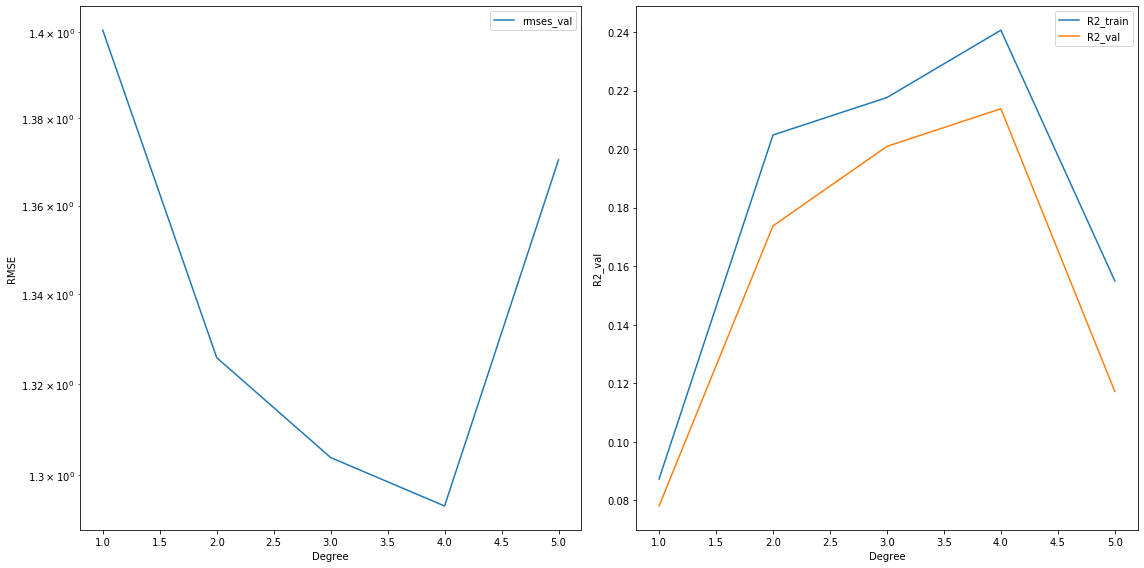

In [68]:
chooseDegree(X,y)

- choose degree 3

## Apply to test set

### Add validation set to train set to obtain more training data

In [69]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)

lin = LinearRegression()

### Training + validation set performance

In [70]:
lin.fit(X_train_poly, y_train)
print(lin.score(X_train_poly, y_train))

0.23352294778621407


### Test set performance

In [71]:
X_test_poly = poly.fit_transform(X_test)
lin.score(X_test_poly,y_test)

0.2219195246076059

- no accurate predictions, features with higher significance required.